In [1]:
%matplotlib inline
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from toolbox.astro import angsep
plt.style.use('jpg')

from astropy.table import Table
from astropy.io import fits
from astropy.visualization import ZScaleInterval, LogStretch, make_lupton_rgb
from matplotlib.colors import LogNorm
zscale = ZScaleInterval()
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from spherical_geometry.polygon import SphericalPolygon
cosmo = FlatLambdaCDM(70, 0.3)

import hhana
from proj_utils import *

fitsdir = os.path.join(os.environ.get('LOCAL_DATA'), 'hsc/stamps/candy/sample-3-6-2017')
get_fn = lambda num, band: os.path.join(fitsdir, 'candy-{}-{}-s16a-wide.fits'.format(num, band.lower()))

In [2]:
g_V = 0.14
Mag = lambda m, D_L: m - 5*np.log10(D_L/u.pc) + 5

In [3]:
def yang_theta(groups):
    theta = (180./np.pi)*hhana.r_vir(groups['logMh(Lest)'], groups['z'], unit='Mpc')
    theta /= cosmo.angular_diameter_distance(groups['z']).value
    return theta

In [4]:
def plot_group(sam, groups, theta, group_mems=None, groups_kws={}, title=''):
    plt.figure(figsize=(8,8))
    plt.scatter(sam['ra'], sam['dec'],
                c=sam['g-i'], vmin=0.7, vmax=0.71, 
                cmap='bwr', s=70, label='Candidates', zorder=100)
    plt.scatter(groups['ra'], groups['dec'], zorder=10,
                c=groups['z'], marker='*', s=300, **groups_kws)
    cb = plt.colorbar(shrink=0.4, aspect=16)
    cb.ax.set_ylabel('z', rotation=0, labelpad=20)
    cb.ax.tick_params('both', length=6)
    xmin, xmax = plt.xlim()
    for row, t in zip(groups, theta):
        cone = SphericalPolygon.from_cone(row['ra'], row['dec'], t, steps=1000)
        ra, dec = list(cone.to_radec())[0]
        ra = ra + 360*(ra<0)
        plt.plot(ra, dec, 'k-')
        if group_mems is not None:
            gals = group_mems[group_mems['group-id']==row['group-id']]
            plt.scatter(gals['ra'], gals['dec'], c='gray', marker='s', alpha=0.3)
    plt.title(title)
    plt.axes().set_aspect('equal')
    plt.xlabel(r'$\delta$ [deg]')
    plt.ylabel(r'$\alpha$ [deg]');

## Find cluster environments 

In [5]:
clusters = {'3.1': {'coord': [181, 1.5], 'size': 1.0}, 
            '3.2': {'coord': [182.5, 1.], 'size': 0.5},
            '1.1': {'coord': [37.0, -2.], 'size': 1.7},
            '2.1': {'coord': [140.0, 1.], 'size': 1.2},
            '3.3': {'coord': [180.5, -0.5], 'size': 1.},
            '4.1': {'coord': [225, 1], 'size': 1.8},
            '4.2': {'coord': [211, -1], 'size': 1.5}}

In [6]:
yang_gals = hhana.SuperCat('yang_gals')
sample = get_sample()
nsa = get_nsa()
yang = get_yang(logMh_min=12.5, zmax=0.07)

## Search near Yang groups

In [7]:
yang_idx, sep, _ = sample.skycoord.match_to_catalog_sky(yang.skycoord)
yang_idx_Mpc, yang_sep_Mpc = find_nearest_in_Mpc(sample, yang, cosmo)

[( 12.575 ,  0.0540456 ) ( 12.524 ,  0.01723567) ( 12.6567,  0.0570962 )]
[( 12.524,  0.01723567)]


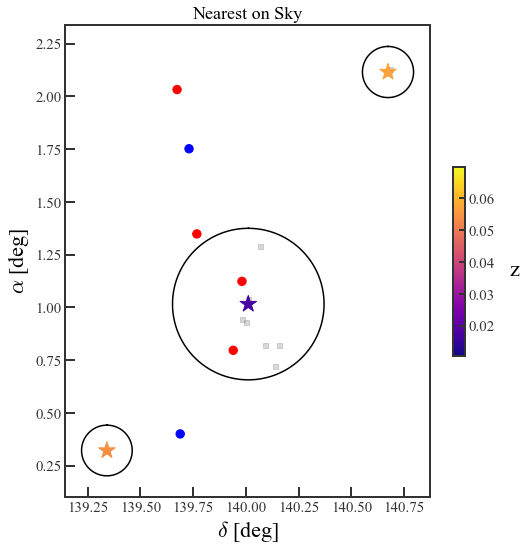

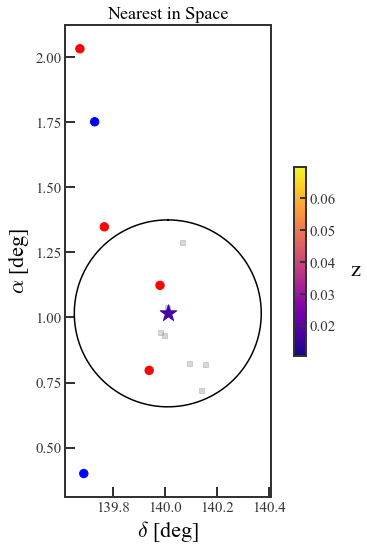

In [8]:
cluster_id = 2.1
clust = clusters[str(cluster_id)]
idx, dist = sample.query_radius(clust['coord'], clust['size'])
groups_kws = dict(vmin=yang['z'].min(), vmax=yang['z'].max(), cmap='plasma')
for title, yidx in zip(['Nearest on Sky', 'Nearest in Space'], [yang_idx, yang_idx_Mpc]):
    yang_groups = np.unique(yang[yidx][idx]['ra', 'dec', 'group-id', 'logMh(Lest)', 'z'])
    theta = yang_theta(yang_groups)
    plot_group(sample[idx], yang_groups, theta, yang_gals, groups_kws, title=title)
    print(yang_groups[['logMh(Lest)', 'z']])

## Search near NSA galaxies

In [9]:
nsa_idx, sep, _ = sample.skycoord.match_to_catalog_sky(nsa.skycoord)
nsa_idx_Mpc, nsa_sep_Mpc = find_nearest_in_Mpc(sample, nsa, cosmo)

[ 0.04771741  0.02082211  0.02090264]
[ 0.01920331  0.02082211  0.02090264]


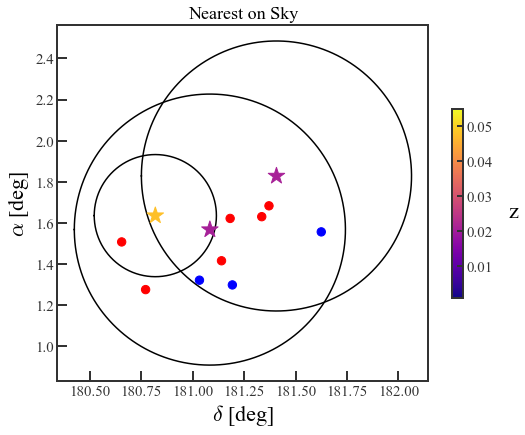

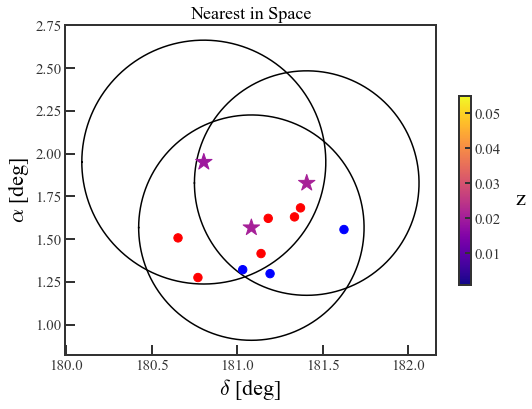

In [10]:
cluster_id = 3.1
clust = clusters[str(cluster_id)]
idx, dist = sample.query_radius(clust['coord'], clust['size'])
kws = dict(vmin=nsa['z'].min(), vmax=nsa['z'].max(), cmap='plasma')

for title, nidx in zip(['Nearest on Sky', 'Nearest in Space'], [nsa_idx, nsa_idx_Mpc]):
    gals = np.unique(nsa[nidx][idx]['ra', 'dec', 'z'])
    theta = (180/np.pi)*1.0/cosmo.angular_diameter_distance(gals['z']).value
    plot_group(sample[idx], gals, theta, groups_kws=kws, title=title)
    print(gals['z'])

In [11]:
clust_2p1_fits = Table.read('data/clust_2.1_fits_g-band.csv')
clust_3p1_fits = Table.read('data/clust_3.1_fits_g-band.csv')
clust_2p1_fits.sort('r_e')
clust_3p1_fits.sort('r_e')
size_cut_3pl = 4.0
size_cut_2pl = 4.0
id_3p1 = clust_3p1_fits['hugs-id']
id_2p1 = clust_2p1_fits['hugs-id']

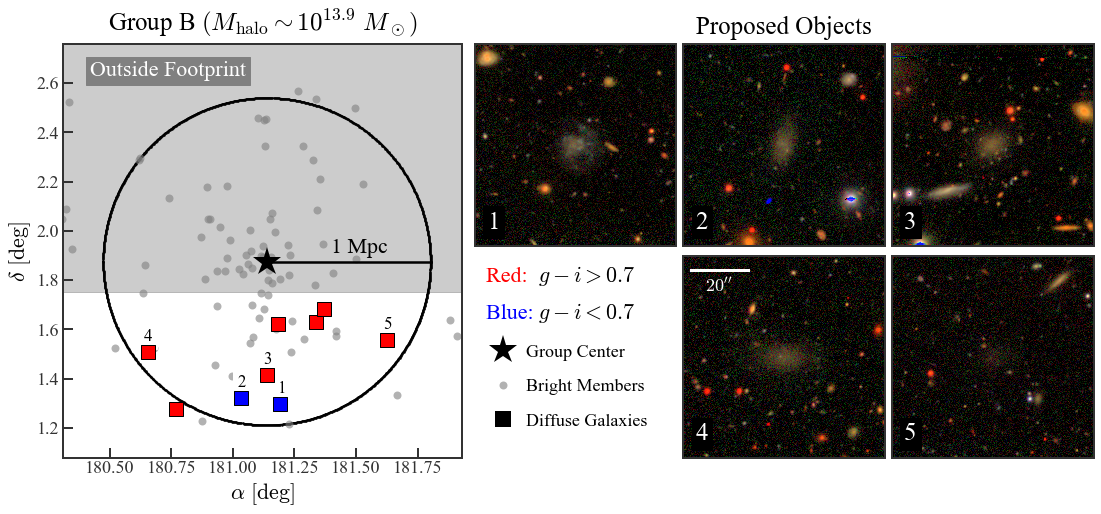

In [14]:
use_rbg = True

fig = plt.figure(figsize=(18, 7))
noticks = dict(xticks=[], yticks=[])
cmap = plt.cm.rainbow

# setup grid
grid = plt.GridSpec(2, 5, wspace=0, hspace=0.05)
ax_env = fig.add_subplot(grid[0:2, 0:2])

ax_env.set_title('Group B $(M_\mathrm{halo}\sim10^{13.9}\ M_\odot)$', fontsize=25, y=1.02)

##################### postage stamps
j = 0
img_axes = []
for i in range(5):
    if i>2:
        j=1
    img_axes.append(fig.add_subplot(grid[0+j:1+j, 2+i-2*j:3+i-2*j], **noticks))
#####################

img_axes[1].set_title('Proposed Objects', fontsize=25, y=1.025)

##################### enviornment 3.1
cluster_id = 3.1
clust = clusters[str(cluster_id)]
idx, dist = sample.query_radius(clust['coord'], clust['size'])
group = np.unique(yang[yang_idx_Mpc][idx])
ax_env.plot(group['ra'], group['dec'], 'k*', markersize=30, label='Group Center')

theta_Mpc = u.radian.to('deg')*1.0/cosmo.angular_diameter_distance(group['z'][0]).value
for t in [theta_Mpc]:#, yang_theta(group)[0]]:
    ra, dec = hhana.plot.sky_cone(None, group['ra'][0], group['dec'][0], t)
    ax_env.plot(ra, dec, c='k', zorder=-10)
    
ax_env.tick_params(axis='both', labelsize=18)
gals = yang_gals[yang_gals['group-id']==group['group-id']]
num = 0

marker = ['s', 'o', '^', '*', 'v']

num = 0
for sam in sample[idx]:
    if sam['hugs-id'] in id_3p1:
        object_mask = clust_3p1_fits['hugs-id']==sam['hugs-id']
        size = clust_3p1_fits[object_mask]['r_e'][0]
        if use_rbg and size>size_cut_3pl:
            R, G, B = [fits.getdata(get_fn(sam['hugs-id'], band)) for band in 'irg']
            img = make_lupton_rgb(R, G, B, stretch=0.5)
            img_axes[num].imshow(img, origin='lower')
            img_axes[num].text(25, 36, str(num+1), backgroundcolor='k',
                               fontsize=25, color='w')
            ax_env.text(sam['ra']-0.015, sam['dec']+0.045, str(num+1), 
                        backgroundcolor='w', fontsize=17, zorder=-5)
            size_kpc = size*cosmo.angular_diameter_distance(group['z'][0]).to('kpc')*u.arcsec.to('rad')
            Vmag = clust_3p1_fits[object_mask]['m_tot'][0] - g_V
            num+=1
        elif size>size_cut_3pl:
            img = fits.getdata(get_fn(sam['hugs-id'], 'i'))
            vmin, vmax = zscale.get(img)
            img_axes[num].imshow(img, origin='lower', vmin=vmin, vmax=vmax)
            num+=1
        cbump = 0.5 if num==5 else 0.0
        kws = dict(vmin=0.7, vmax=0.71, marker='s', c=sam['g-i']+cbump,  cmap='bwr')
        ax_env.scatter(sam['ra'], sam['dec'], s=220, edgecolor='k', **kws)
        
shape = img.shape
start = 15.0
end = start + 20/0.168
y=0.93*shape[0]
img_axes[3].axhline(y=y, xmin=start/shape[1], xmax=end/shape[1], color='w', lw=3.0)
img_axes[3].text((start+end)/2 - 0.07*shape[1], 
        y - 0.105*shape[0], 
        r'$20^{\prime\prime}$', color='w', fontsize=18)

text = fig.add_subplot(grid[1:2, 2:3], **noticks)
text.axis('off')

y = 0.87
dy = 0.18
xmin = 0.07
dx = 0.25
text.text(xmin, y, 'Red: ', fontsize=22, color='r')
text.text(xmin+dx, y, r'$g-i>0.7$', fontsize=22)
text.text(xmin, y - dy, 'Blue: ', fontsize=22, color='b')
text.text(xmin+dx, y-dy, r'$g-i<0.7$', fontsize=22)

ax_env.plot(gals['ra'], gals['dec'], 'o', c='gray', alpha=0.6,
            markersize=8, zorder=-6, label='Bright Members')
ax_env.plot([], [], 'sk', label='Diffuse Galaxies', markersize=16)
ax_env.legend(loc=(1.038, 0.05), fontsize=18, labelspacing=1)

xmin, xmax = ax_env.get_xlim()
ymin, ymax = ax_env.get_ylim()
ax_env.fill_between([xmin-10, xmax+10], 1.75, ymax+5, color='k', alpha=0.2, zorder=-100)
ax_env.text(180.42, 2.63, 'Outside Footprint', fontsize=22, color='w', backgroundcolor='gray')
ax_env.set_xlim(xmin+0.3, xmax-0.3)
ax_env.set_ylim(ymin-0.05, ymax-0.16)
ax_env.set_aspect('equal')

xmin, xmax = ax_env.get_xlim()
diff = xmax - xmin
ra_min = (group['ra'] - xmin)/diff
ra_max = (group['ra'] + theta_Mpc - xmin)/diff
ax_env.axhline(y=group['dec'], xmin=ra_min, xmax=ra_max, lw=2.5)
ax_env.text(181.4, 1.91, '1 Mpc', fontsize=22)

ax_env.set_xlabel(r'$\alpha\ \mathrm{[deg]}$')
ax_env.set_ylabel(r'$\delta\ \mathrm{[deg]}$');
#fig.savefig('figures/group_2.pdf');

In [15]:
eye_candy = {'g': pd.read_csv('data/eye_2.1_fits_g-band.csv'),
             'i': pd.read_csv('data/eye_2.1_fits_i-band.csv')}
eye_candy['dir'] = '/Users/protostar/local_data/hsc/eye-candy-HST-C25/'

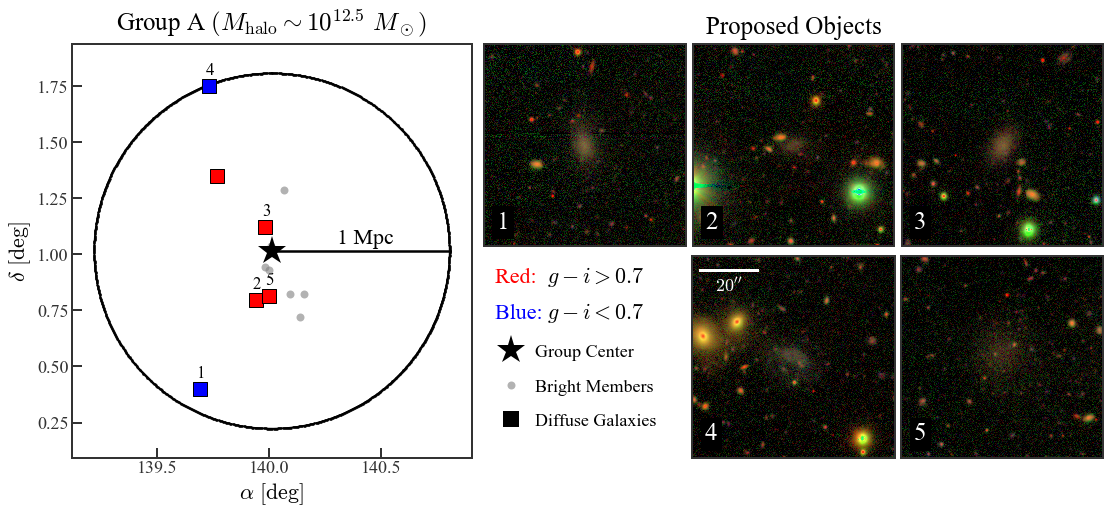

In [16]:
use_rbg = True

fig = plt.figure(figsize=(18, 7))
noticks = dict(xticks=[], yticks=[])
cmap = plt.cm.rainbow

# setup grid
grid = plt.GridSpec(2, 5, wspace=0, hspace=0.05)
ax_env = fig.add_subplot(grid[0:2, 0:2])
ax_env.set_title('Group A $(M_\mathrm{halo}\sim10^{12.5}\ M_\odot)$', fontsize=25, y=1.02)

##################### postage stamps
j = 0
img_axes = []
for i in range(5):
    if i>2:
        j=1
    img_axes.append(fig.add_subplot(grid[0+j:1+j, 2+i-2*j:3+i-2*j], **noticks))
img_axes[1].set_title('Proposed Objects', fontsize=25, y=1.025)
#####################

##################### enviornment 2.1
cluster_id = 2.1
clust = clusters[str(cluster_id)]
idx, dist = sample.query_radius(clust['coord'], clust['size'])
group = np.unique(yang[yang_idx_Mpc][idx])
ax_env.plot(group['ra'], group['dec'], 'k*', markersize=30, label='Group Center')

theta_Mpc = u.radian.to('deg')*1.0/cosmo.angular_diameter_distance(group['z'][0]).value
for t in [theta_Mpc]:#, yang_theta(group)[0]]:
    ra, dec = hhana.plot.sky_cone(None, group['ra'][0], group['dec'][0], t)
    ax_env.plot(ra, dec, c='k', zorder=-4)
ax_env.tick_params(axis='both', labelsize=18)
gals = yang_gals[yang_gals['group-id']==group['group-id']]
num = 0

marker = ['s', 'o', '^', 'p', 'v']
for sam in sample[idx]:
    if sam['hugs-id'] in id_2p1:
        object_mask = clust_2p1_fits['hugs-id']==sam['hugs-id']
        size = clust_2p1_fits[object_mask]['r_e'][0]
        if use_rbg and size>size_cut_2pl:
            R, G, B = [fits.getdata(get_fn(sam['hugs-id'], band)) for band in 'irg']
            img = make_lupton_rgb(R, G, B, stretch=0.5)
            img_axes[num].imshow(img, origin='lower')
            img_axes[num].text(25, 36, str(num+1), backgroundcolor='k',
                               fontsize=25, color='w')
            ax_env.text(sam['ra']-0.015, sam['dec']+0.051, str(num+1), 
                        backgroundcolor='w', fontsize=17, zorder=-5)
            size_kpc = size*cosmo.angular_diameter_distance(group['z'][0]).to('kpc')*u.arcsec.to('rad')
            
            Vmag = clust_2p1_fits[object_mask]['m_tot'][0] - g_V
            num+=1
        elif size>size_cut_2pl:
            img = fits.getdata(get_fn(sam['hugs-id'], 'i'))
            vmin, vmax = zscale.get(img)
            img_axes[num].imshow(img, origin='lower', vmin=vmin, vmax=vmax)
            num+=1
        if sam['dec']<2.0:
            kws = dict(vmin=0.7, vmax=0.71, marker='s', c=sam['g-i'],  cmap='bwr')
            ax_env.scatter(sam['ra'], sam['dec'], s=220, edgecolor='k', **kws)
            
kws = dict(vmin=0.7, vmax=0.71, marker='s', 
           c= eye_candy['g'].m_tot-eye_candy['i'].m_tot,  cmap='bwr')
ax_env.scatter(eye_candy['g']['ra'], eye_candy['g']['dec'], s=220, 
               edgecolor='k', label=None, **kws)
fn = lambda band: eye_candy['dir']+'candy-0-'+band+'-s16a-wide.fits'
R, G, B = [fits.getdata(fn(band)) for band in 'irg']
img = make_lupton_rgb(R, G, B, stretch=0.5)
img_axes[num].imshow(img, origin='lower')
img_axes[num].text(25, 36, str(num+1), backgroundcolor='k',
                   fontsize=25, color='w')
ax_env.text(eye_candy['g']['ra']-0.015, eye_candy['g']['dec']+0.051, str(num+1), 
            backgroundcolor='none', fontsize=17, zorder=-4.5)
sam = eye_candy['g']
size_kpc = sam['r_e'][0]*cosmo.angular_diameter_distance(group['z'][0]).to('kpc')*u.arcsec.to('rad')
shape = img.shape
start = 15.0
end = start + 20/0.168
y=0.93*shape[0]
img_axes[3].axhline(y=y, xmin=start/shape[1], xmax=end/shape[1], color='w', lw=3.0)
img_axes[3].text((start+end)/2 - 0.07*shape[1], 
        y - 0.105*shape[0], 
        r'$20^{\prime\prime}$', color='w', fontsize=18)

text = fig.add_subplot(grid[1:2, 2:3], **noticks)
text.axis('off')

y = 0.87
dy = 0.18
xmin = 0.07
dx = 0.25
text.text(xmin, y, 'Red: ', fontsize=22, color='r')
text.text(xmin+dx, y, r'$g-i>0.7$', fontsize=22)
text.text(xmin, y - dy, 'Blue: ', fontsize=22, color='b')
text.text(xmin+dx, y-dy, r'$g-i<0.7$', fontsize=22)

ax_env.plot(gals['ra'], gals['dec'], 'o', c='gray', alpha=0.6,
            markersize=8, zorder=-4, label='Bright Members')
ax_env.plot([], [], 'sk', label='Diffuse Galaxies', markersize=16)
ax_env.legend(loc=(1.038, 0.05), fontsize=18, labelspacing=1)


ax_env.legend(loc=(1.036, 0.05), fontsize=18, labelspacing=1)

xmin, xmax = ax_env.get_xlim()
ymin, ymax = ax_env.get_ylim()
ax_env.set_ylim(ymin-0.05, ymax+0.05)
ax_env.set_xlim(xmin-0.02, xmax+0.02)
ax_env.set_aspect('equal')

xmin, xmax = ax_env.get_xlim()
diff = xmax - xmin
ra_min = (group['ra'] - xmin)/diff
ra_max = (group['ra'] + theta_Mpc - xmin)/diff
ax_env.axhline(y=group['dec'], xmin=ra_min, xmax=ra_max, lw=2.5)
ax_env.text(140.3, 1.05, '1 Mpc', fontsize=22)

ax_env.set_xlabel(r'$\alpha\ \mathrm{[deg]}$')
ax_env.set_ylabel(r'$\delta\ \mathrm{[deg]}$');
#fig.savefig('figures/group_1.pdf');
#####################